## Initial imports and helper function
The ``show()`` function can be used inside Jupyter notebooks to show the chemical system. If you do not use Jupyter, the function can be ignored.

In [1]:
from scm.plams import *
import os
import numpy as np
from ase.visualize.plot import plot_atoms
import matplotlib.pyplot as plt


def show(mol, figsize=None, rotation=None, **kwargs):
    """Show a molecule in a Jupyter notebook"""
    plt.figure(figsize=figsize or (2, 2))
    plt.axis("off")
    rotation = rotation or ("80x,10y,0z")
    plot_atoms(toASE(mol), rotation=rotation, **kwargs)

Before running AMS jobs, you need to call the PLAMS ``init()`` function:

In [2]:
init()

PLAMS working folder: /home/hellstrom/adfhome/userdoc/Tutorials/MolecularDynamicsAndMonteCarlo/MDintroPython/plams_workdir


## Create a box of methane


First, create a gasphase methane molecule:

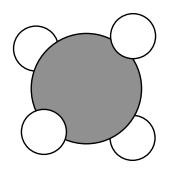

In [3]:
single_molecule = from_smiles("C", forcefield="uff")  # or use Molecule('your-own-file.xyz')
show(single_molecule)

You can easily create a box with a liquid or gas of a given density. For more advanced options, see the Packmol example.

Lattice vectors of the box:
[[8.106820570931148, 0.0, 0.0], [0.0, 8.106820570931148, 0.0], [0.0, 0.0, 8.106820570931148]]


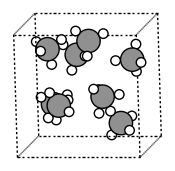

In [4]:
box = packmol(
    single_molecule,
    n_molecules=8,
    region_names="methane",
    density=0.4,  # g/cm^3
)
print("Lattice vectors of the box:\n{}".format(box.lattice))
show(box)

Before running an MD simulation, it is usually a good idea to do a quick geometry optimization (preoptimization).

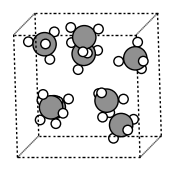

In [5]:
box = preoptimize(box, model="UFF", maxiterations=50)
show(box)

### Run an NVE simulation with UFF

In an NVE simulation, the total energy (kinetic + potential) is constant. 

The initial velocities can either be 

* read from a file (a previous simulation), or 

* be generated to follow the Maxwell-Boltzmann distribution at a certain temperature.

Here, we will initialize the velocities corresponding to a temperature of 300 K.

In [6]:
s = Settings()
s.input.ForceField.Type = "UFF"
s.runscript.nproc = 1  # run in serial

nve_job = AMSNVEJob(
    molecule=box,
    settings=s,
    name="NVE-sim-1",
    temperature=300,  # initial velocities from Maxwell-Boltzmann distribution, 300 K
    nsteps=1000,
    samplingfreq=50,
    timestep=1.0,  # femtoseconds
)

When calling ``nve_job.run()``, you can set ``watch=True`` to interactively see the progress of the MD simulation.

In [7]:
nve_job.run(watch=True);

[16.12|13:57:34] JOB NVE-sim-1 STARTED
[16.12|13:57:34] JOB NVE-sim-1 RUNNING
[16.12|13:57:34] NVE-sim-1: AMS 2022.204  RunTime: Dec16-2022 13:57:34  ShM Nodes: 1  Procs: 1
[16.12|13:57:34] NVE-sim-1: Starting MD calculation:
[16.12|13:57:34] NVE-sim-1: --------------------
[16.12|13:57:34] NVE-sim-1: Molecular Dynamics
[16.12|13:57:34] NVE-sim-1: --------------------
[16.12|13:57:34] NVE-sim-1:          Step       Time    Temp.         E Pot        Pressure        Volume
[16.12|13:57:34] NVE-sim-1:                     (fs)      (K)          (au)           (MPa)         (A^3)
[16.12|13:57:34] NVE-sim-1: GuessUFFBonds
[16.12|13:57:34] NVE-sim-1:             0       0.00     300.      -0.03207         239.478         532.8
[16.12|13:57:34] NVE-sim-1:            50      50.00     177.      -0.00859        -131.982         532.8
[16.12|13:57:34] NVE-sim-1:           100     100.00     271.      -0.02647          80.591         532.8
[16.12|13:57:34] NVE-sim-1:           150     150.00     

The main output file from an MD simulation is called **ams.rkf**. It contains the trajectory and other properties (energies, velocities, ...). You can open the file 

* in the AMSmovie graphical user interface to play (visualize) the trajectory. 

* in the KFbrowser module (expert mode) to find out where on the file various properties are stored.

Call the ``job.results.rkfpath()`` method to find out where the file is:

In [8]:
print(nve_job.results.rkfpath())

/home/hellstrom/adfhome/userdoc/Tutorials/MolecularDynamicsAndMonteCarlo/MDintroPython/plams_workdir/NVE-sim-1/ams.rkf


Use ``job.results.readrkf()`` to directly read from the ams.rkf file:

In [9]:
n_frames = nve_job.results.readrkf("MDHistory", "nEntries")
print("There are {} frames in the trajectory".format(n_frames))

There are 21 frames in the trajectory


Let's plot the potential, kinetic, and total energies:

In [10]:
def plot_energies(
    job, title=None, kinetic_energy=True, potential_energy=True, total_energy=True, conserved_energy=False
):
    time = job.results.get_history_property("Time", "MDHistory")
    plt.figure(figsize=(5, 3))
    if kinetic_energy:
        kin_e = job.results.get_history_property("KineticEnergy", "MDHistory")
        plt.plot(time, kin_e, label="Kinetic Energy")
    if potential_energy:
        pot_e = job.results.get_history_property("PotentialEnergy", "MDHistory")
        plt.plot(time, pot_e, label="Potential Energy")
    if total_energy:
        tot_e = job.results.get_history_property("TotalEnergy", "MDHistory")
        plt.plot(time, tot_e, label="Total Energy")
    if conserved_energy:
        conserved_e = job.results.get_history_property("ConservedEnergy", "MDHistory")
        plt.plot(time, conserved_e, label="Conserved Energy")
    plt.legend()
    plt.xlabel("Time (fs)")
    plt.ylabel("Energy (Ha)")
    plt.title(title or job.name + " Energies")
    plt.show()

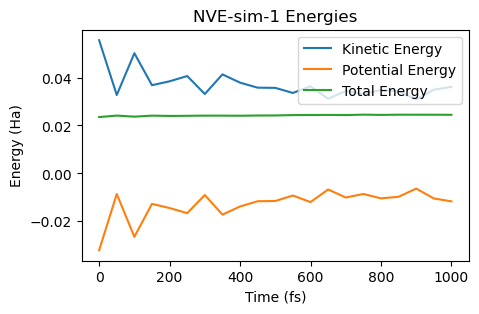

In [11]:
plot_energies(nve_job)

During the NVE simulation, kinetic energy is converted into potential energy and vice versa, but the total energy remains constant.

Let's also show an image of the final frame. The atoms of some molecules are split across the periodic boundary.

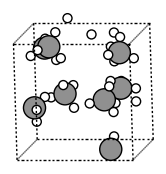

In [12]:
show(nve_job.results.get_main_molecule())

## NVT simulation

In an NVT simulation, a thermostat keeps the temperature (kinetic energy) in check. The time constant tau (in femtoseconds) indicates how "strong" the thermostat is. For now, let's set a Berendsen thermostat with a time constant of 100 fs.

In [13]:
nvt_job = AMSNVTJob(
    molecule=box,
    settings=s,
    name="NVT-sim-1",
    nsteps=1000,
    samplingfreq=50,
    timestep=1.0,  # femtoseconds
    temperature=300,
    thermostat="Berendsen",
    tau=100,  # femtoseconds
)
nvt_job.run();

[16.12|13:57:37] JOB NVT-sim-1 STARTED
[16.12|13:57:37] JOB NVT-sim-1 RUNNING
[16.12|13:57:38] JOB NVT-sim-1 FINISHED
[16.12|13:57:38] JOB NVT-sim-1 SUCCESSFUL


In [14]:
def plot_temperature(job, title=None):
    time = job.results.get_history_property("Time", "MDHistory")
    temperature = job.results.get_history_property("Temperature", "MDHistory")
    plt.figure(figsize=(5, 3))
    plt.plot(time, temperature)
    plt.xlabel("Time (fs)")
    plt.ylabel("Temperature (K)")
    plt.title(title or job.name + " Temperature")
    plt.show()

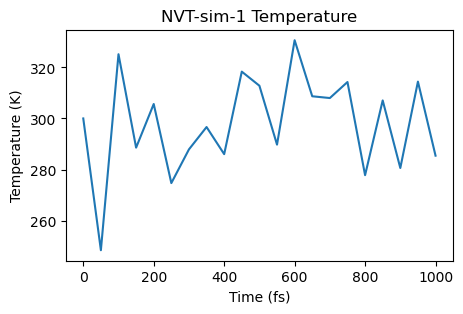

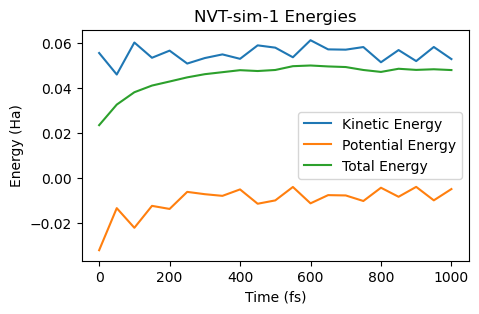

In [15]:
plot_temperature(nvt_job)
plot_energies(nvt_job)

In an NVT simulation, the total energy is not conserved. Instead, the quantity known as "Conserved Energy" is conserved:

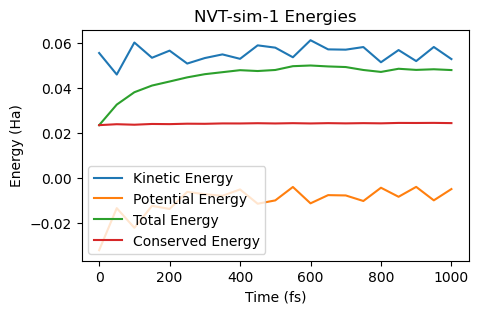

In [16]:
plot_energies(nvt_job, conserved_energy=True)

## NPT simulation

In an NPT simulation, a barostat is used to keep the pressure constant (fluctuating around a given value). The instantaneous pressure can fluctuate quite wildly, even with a small time constant for the barostat.

Let's run an NPT simulation with the same thermostat as before and with a barostat set at 1 bar. 

**Note**: It is usually good to pre-equilibrate a simulation in NVT before switching on the barostat. Below we demonstrate the ``restart_from`` function, which will restart from ``nvt_job`` (final frame and velocities). You can also use ``restart_from`` together with AMSNVEJob or AMSNVTJob.

In [17]:
npt_job = AMSNPTJob.restart_from(
    nvt_job,
    name="npt",
    barostat="Berendsen",
    pressure=1e5,  # Pa
    barostat_tau=1000,  # fs
    equal="XYZ",  # scale all lattice vectors equally
)

npt_job.run();

[16.12|13:57:39] JOB npt STARTED
[16.12|13:57:39] JOB npt RUNNING
[16.12|13:57:41] JOB npt FINISHED
[16.12|13:57:41] JOB npt SUCCESSFUL


In [18]:
def moving_average(x, y, window: int):
    if not window:
        return x, y
    window = min(len(x) - 1, window)
    if window <= 1:
        return x, y
    ret_x = np.convolve(x, np.ones(window) / window, mode="valid")
    ret_y = np.convolve(y, np.ones(window) / window, mode="valid")
    return ret_x, ret_y


def plot_pressure(job, title=None, window: int = None):
    time = job.results.get_history_property("Time", "MDHistory")
    pressure = job.results.get_history_property("Pressure", "MDHistory")
    pressure = Units.convert(pressure, "au", "bar")  # convert from atomic units to bar
    time, pressure = moving_average(time, pressure, window)
    plt.figure(figsize=(5, 3))
    plt.plot(time, pressure)
    plt.xlabel("Time (fs)")
    plt.ylabel("Pressure (bar)")
    plt.title(title or job.name + " Pressure")
    plt.show()

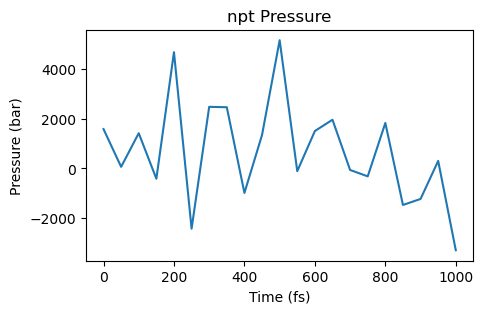

In [19]:
plot_pressure(npt_job)

Those are quite some fluctuations! Especially for the pressure it can be useful to **plot a moving average**. Here the ``window`` parameter gives the number of frames in the trajectory to average over.

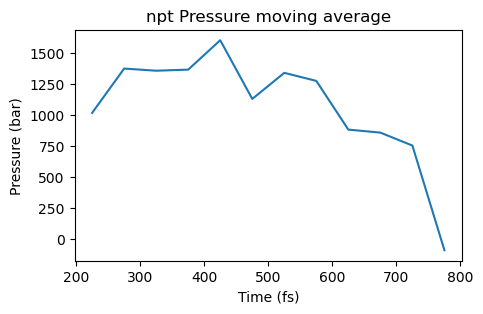

In [20]:
plot_pressure(npt_job, window=10, title="npt Pressure moving average")

From this moving average it is easier to see that the pressure is too high compared to the target pressure of 1 bar, so the simulation is not yet in equilibrium.

Let's also plot the density as a function of time:

In [21]:
def plot_density(job, title=None, window: int = None):
    time = job.results.get_history_property("Time", "MDHistory")
    density = job.results.get_history_property("Density", "MDHistory")
    density = np.array(density) * Units.convert(1.0, "au", "kg") / Units.convert(1.0, "bohr", "m") ** 3
    time, density = moving_average(time, density, window)
    plt.figure(figsize=(5, 3))
    plt.plot(time, density)
    plt.xlabel("Time (fs)")
    plt.ylabel("Density (kg/m^3)")
    plt.title(title or job.name + " Density")
    plt.show()

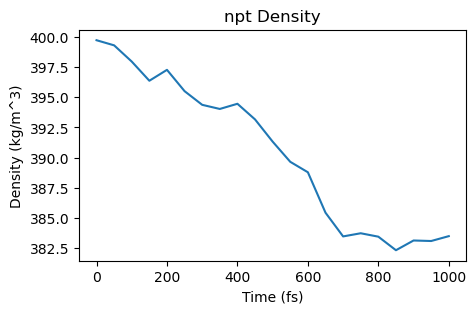

In [22]:
plot_density(npt_job)

Since the pressure was too high, the barostat increases the size of the simulation box (which decreases the density). Note that the initial density was 400 kg/m^3 which matches the density given to the ``packmol`` function at the top (0.4 g/cm^3)!

## Equilibration and Mean squared displacement (diffusion coefficient)

The mean squared displacement is in practice often calculated from NVT simulations. This is illustrated here. However, best practice is to instead 

* average over several NVE simulations that have been initialized with velocities from NVT simulations, and to
* extrapolate the diffusion coefficient to infinite box size

Those points will be covered later. Here, we just illustrate the simplest possible way (that is also the most common in practice).

The mean squared displacement is only meaningful for fully **equilibrated** simulations. Let's first run a reasonably long equilibration simulation, and then a production simulation. These simulations may take a few minutes to complete.

[16.12|13:57:41] JOB NVT-equilibration-1 STARTED
[16.12|13:57:41] JOB NVT-equilibration-1 RUNNING
[16.12|13:58:50] JOB NVT-equilibration-1 FINISHED
[16.12|13:58:50] JOB NVT-equilibration-1 SUCCESSFUL


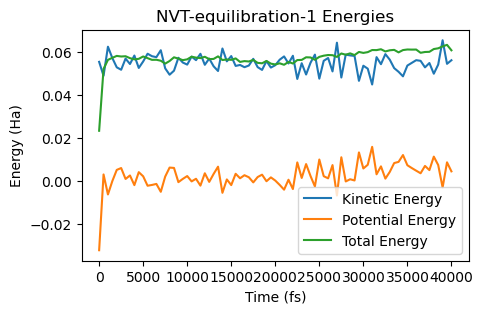

In [23]:
nvt_eq_job = AMSNVTJob(
    molecule=box,
    settings=s,
    name="NVT-equilibration-1",
    temperature=300,
    thermostat="Berendsen",
    tau=200,
    timestep=1.0,
    nsteps=40000,
    samplingfreq=500,
)
nvt_eq_job.run()
plot_energies(nvt_eq_job)

The energies seem equilibrated, so let's run a production simulation and switch to the NHC (Nose-Hoover) thermostat

In [24]:
nvt_prod_job = AMSNVTJob.restart_from(
    nvt_eq_job, name="NVT-production-1", nsteps=50000, thermostat="NHC", samplingfreq=100
)

nvt_prod_job.run();

[16.12|13:58:50] JOB NVT-production-1 STARTED
[16.12|13:58:50] JOB NVT-production-1 RUNNING
[16.12|14:00:17] JOB NVT-production-1 FINISHED
[16.12|14:00:17] JOB NVT-production-1 SUCCESSFUL


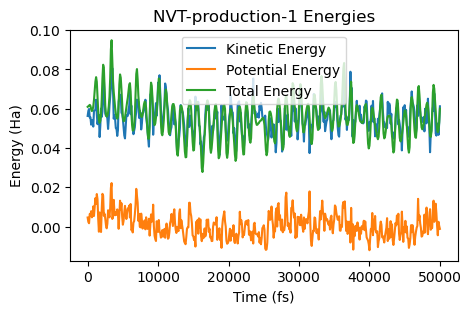

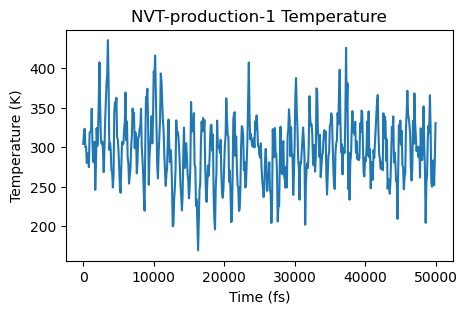

In [25]:
plot_energies(nvt_prod_job)
plot_temperature(nvt_prod_job)

The simulation seems to be sampling an equilibrium distribution, so it's safe to calculate the mean squared displacement. Let's use the ``AMSMSDJob`` for this. We'll also specify to only calculate the MSD for the carbon atoms of the methane molecules.

In [26]:
atom_indices = [i for i, at in enumerate(nvt_prod_job.results.get_main_molecule(), 1) if at.symbol == "C"]
print("Calculating MSD for carbon atoms with indices {}".format(atom_indices))
msd_job = AMSMSDJob(
    nvt_prod_job,
    name="msd-" + nvt_prod_job.name,
    atom_indices=atom_indices,  # indices start with 1 for the first atom
    max_correlation_time_fs=8000,  # max correlation time must be set before running the job
    start_time_fit_fs=3000,  # start_time_fit can also be changed later in the postanalysis
)
msd_job.run();

Calculating MSD for carbon atoms with indices [1, 6, 11, 16, 21, 26, 31, 36]
[16.12|14:00:17] JOB msd-NVT-production-1 STARTED
[16.12|14:00:17] JOB msd-NVT-production-1 RUNNING
[16.12|14:00:17] JOB msd-NVT-production-1 FINISHED
[16.12|14:00:18] JOB msd-NVT-production-1 SUCCESSFUL


In [27]:
def plot_msd(job, start_time_fit_fs=None):
    """job: an AMSMSDJob"""
    time, msd = job.results.get_msd()
    fit_result, fit_x, fit_y = job.results.get_linear_fit(start_time_fit_fs=start_time_fit_fs)
    # the diffusion coefficient can also be calculated as fit_result.slope/6 (ang^2/fs)
    diffusion_coefficient = job.results.get_diffusion_coefficient(start_time_fit_fs=start_time_fit_fs)  # m^2/s
    plt.figure(figsize=(5, 3))
    plt.plot(time, msd, label="MSD")
    plt.plot(fit_x, fit_y, label="Linear fit slope={:.5f} ang^2/fs".format(fit_result.slope))
    plt.legend()
    plt.xlabel("Correlation time (fs)")
    plt.ylabel("Mean square displacement (ang^2)")
    plt.title("MSD: Diffusion coefficient = {:.2e} m^2/s".format(diffusion_coefficient))
    plt.show()

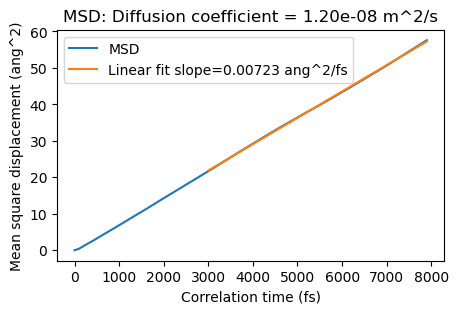

In [28]:
plot_msd(msd_job)

In the above graph, the MSD is a straight line. That is a good sign. If the line isn't straight at large correlation times, you would need to run a longer simulation. The diffusion coefficient = slope/6.

The plot ends at 8000 fs (``max_correlation_time_fs``), and the linear fit is started from 3000 fs (``start_time_fit_fs``). You can also change the start of the linear fit in the postprocessing:

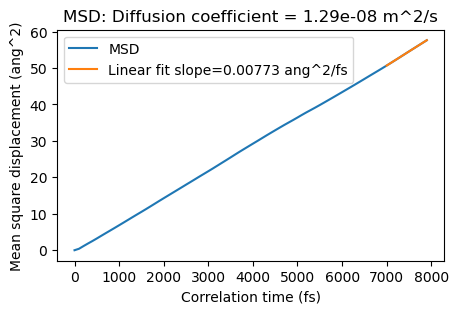

In [29]:
plot_msd(msd_job, start_time_fit_fs=7000)

## Radial distribution function

Similarly to the MSD, a radial distribution function (RDF) should only be calculated for an **equilibrated** simulation.

Let's calculate and plot the C-H RDF. Note that the RDF should only be calculated for distances up to half the shortest lattice vector length (for orthorhombic cells).

In [30]:
mol = nvt_prod_job.results.get_main_molecule()
atom_indices = [i for i, at in enumerate(mol, 1) if at.symbol == "C"]
atom_indices_to = [i for i, at in enumerate(mol, 1) if at.symbol == "H"]

# rmax = half the shortest box length for orthorhombic cells
rmax = min([mol.lattice[0][0], mol.lattice[1][1], mol.lattice[2][2]]) / 2

rdf_job = AMSRDFJob(
    nvt_prod_job,
    name="rdf-C-H-" + nvt_prod_job.name,
    atom_indices=atom_indices,  # from C
    atom_indices_to=atom_indices_to,  # to H
    rmin=0.5,
    rmax=rmax,
    rstep=0.1,
)
rdf_job.run();

[16.12|14:00:18] JOB rdf-C-H-NVT-production-1 STARTED
[16.12|14:00:18] JOB rdf-C-H-NVT-production-1 RUNNING
[16.12|14:00:18] JOB rdf-C-H-NVT-production-1 FINISHED
[16.12|14:00:18] JOB rdf-C-H-NVT-production-1 SUCCESSFUL


In [31]:
def plot_rdf(job, title=""):
    plt.figure(figsize=(5, 3))
    r, rdf = job.results.get_rdf()
    plt.plot(r, rdf)
    plt.xlabel("r (angstrom)")
    plt.ylabel("g(r)")
    plt.title(title or job.name + " RDF")
    plt.show()

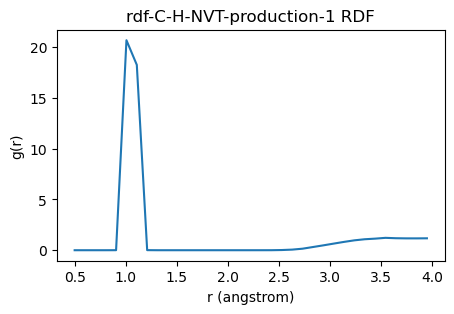

In [32]:
plot_rdf(rdf_job)

The covalent C-H bonds give rise to the peak slightly above 1.0 angstrom. The RDF then slowly approaches a value of 1, which is the expected value for an ideal gas.

## Relation to AMSJob and AMSAnalysisJob

The ``AMSNVEJob``, ``AMSNVTJob``, and ``AMSNPTJob`` classes are just like normal ``AMSJob``. The arguments populate the job's ``settings``.

Similarly, ``AMSMSDJob``, ``AMSRDFJob``, and ``AMSVACFJob`` are normal ``AMSAnalysisJob``.

Let's print the AMS input for the ``nvt_prod_job``. Note that the initial velocities (and the structure) come from the equilibration job.

In [33]:
print(nvt_prod_job.get_input())

MolecularDynamics
  CalcPressure False
  Checkpoint
    Frequency 1000000
  End
  InitialVelocities
    File /home/hellstrom/adfhome/userdoc/Tutorials/MolecularDynamicsAndMonteCarlo/MDintroPython/plams_workdir/NVT-equilibration-1/ams.rkf
    Type FromFile
  End
  NSteps 50000
  Thermostat
    Tau 200
    Temperature 300
    Type NHC
  End
  TimeStep 1.0
  Trajectory
    SamplingFreq 100
    WriteBonds True
    WriteCharges True
    WriteEngineGradients False
    WriteMolecules True
    WriteVelocities True
  End
End

Task MolecularDynamics

system
  Atoms
              C       4.8991753975       7.9740278473       6.3775697371 region=methane
              H       4.8683467538       8.2137820200       7.4458000633 region=methane
              H       4.1673367662       7.2744382792       6.0825790746 region=methane
              H       5.9205406013       7.4765392797       6.3581212674 region=methane
              H       4.9558376608       0.7783342389       5.7618450121 region=methan

And similarly the input to the AMS MD postanalysis program for the ``msd_job``:

In [34]:
print(msd_job.get_input())

MeanSquareDisplacement
  Atoms
    Atom 1
    Atom 6
    Atom 11
    Atom 16
    Atom 21
    Atom 26
    Atom 31
    Atom 36
  end
  MaxStep 80
  Property DiffusionCoefficient
  StartTimeSlope 3000
end

Task MeanSquareDisplacement

TrajectoryInfo
  Trajectory
    KFFileName /home/hellstrom/adfhome/userdoc/Tutorials/MolecularDynamicsAndMonteCarlo/MDintroPython/plams_workdir/NVT-production-1/ams.rkf
  end
end




## Velocity autocorrelation function, power spectrum, AMSNVESpawner

The Fourier transform of the velocity autocorrelation function gives the power spectrum, containing characteristic frequencies of all the vibrations, rotations, and translations of the molecules.

To calculate the velocity autocorrelation function, you need to

* run several short NVE simulations with equilibrated initial velocities
* write the velocities to disk every step
* calculate the autocorrelation function

For the first two steps, we'll use the ``AMSNVESpawnerJob`` class, initializing NVE simulations from evenly spaced frames in the ``nvt_prod_job`` job. For the last step, we'll use the ``AMSVACFJob``.

In [35]:
nvespawner_job = AMSNVESpawnerJob(
    nvt_prod_job,
    name="nvespawner-" + nvt_prod_job.name,
    n_nve=3,  # the number of NVE simulations to run
    samplingfreq=1,  # write to disk every frame for velocity autocorrelation
    writevelocities=True,
    timestep=1.0,  # ideally use smaller timestep
    nsteps=3000,  # 3000 steps (here = 3000 fs) is very short, for demonstration purposes only
)
nvespawner_job.run();

[16.12|14:00:18] JOB nvespawner-NVT-production-1 STARTED
[16.12|14:00:18] JOB nvespawner-NVT-production-1 RUNNING
[16.12|14:00:18] JOB nvespawner-NVT-production-1/nve1 STARTED
[16.12|14:00:18] JOB nvespawner-NVT-production-1/nve1 RUNNING
[16.12|14:00:28] JOB nvespawner-NVT-production-1/nve1 FINISHED
[16.12|14:00:28] JOB nvespawner-NVT-production-1/nve1 SUCCESSFUL
[16.12|14:00:28] JOB nvespawner-NVT-production-1/nve2 STARTED
[16.12|14:00:28] JOB nvespawner-NVT-production-1/nve2 RUNNING
[16.12|14:00:38] JOB nvespawner-NVT-production-1/nve2 FINISHED
[16.12|14:00:38] JOB nvespawner-NVT-production-1/nve2 SUCCESSFUL
[16.12|14:00:38] JOB nvespawner-NVT-production-1/nve3 STARTED
[16.12|14:00:38] JOB nvespawner-NVT-production-1/nve3 RUNNING
[16.12|14:00:48] JOB nvespawner-NVT-production-1/nve3 FINISHED
[16.12|14:00:48] JOB nvespawner-NVT-production-1/nve3 SUCCESSFUL
[16.12|14:00:48] JOB nvespawner-NVT-production-1 FINISHED
[16.12|14:00:50] JOB nvespawner-NVT-production-1 SUCCESSFUL


Let's then create the AMSVACFJobs. The previous NVE jobs are accessed by ``nvespawner_job.children.values()``:

In [36]:
vacf_jobs = []
for job in nvespawner_job.children.values():
    vacf_job = AMSVACFJob(
        job,
        name="vacf-" + job.name + "-" + nvespawner_job.name,
        max_correlation_time_fs=1000,  # 1000 fs is very short, for demo purposes only
    )
    vacf_jobs.append(vacf_job)
    vacf_jobs[-1].run();

[16.12|14:00:50] JOB vacf-nve1-nvespawner-NVT-production-1 STARTED
[16.12|14:00:50] JOB vacf-nve1-nvespawner-NVT-production-1 RUNNING
[16.12|14:00:51] JOB vacf-nve1-nvespawner-NVT-production-1 FINISHED
[16.12|14:00:51] JOB vacf-nve1-nvespawner-NVT-production-1 SUCCESSFUL
[16.12|14:00:51] JOB vacf-nve2-nvespawner-NVT-production-1 STARTED
[16.12|14:00:51] JOB vacf-nve2-nvespawner-NVT-production-1 RUNNING
[16.12|14:00:52] JOB vacf-nve2-nvespawner-NVT-production-1 FINISHED
[16.12|14:00:52] JOB vacf-nve2-nvespawner-NVT-production-1 SUCCESSFUL
[16.12|14:00:52] JOB vacf-nve3-nvespawner-NVT-production-1 STARTED
[16.12|14:00:52] JOB vacf-nve3-nvespawner-NVT-production-1 RUNNING
[16.12|14:00:53] JOB vacf-nve3-nvespawner-NVT-production-1 FINISHED
[16.12|14:00:54] JOB vacf-nve3-nvespawner-NVT-production-1 SUCCESSFUL


Let's get and plot the average velocity autocorrelation function and power spectrum

In [37]:
def plot_vacf(vacf_jobs):
    """vacf_jobs is a list of AMSVACFJob, plot the average velocity autocorrelation function"""
    x, y = zip(*[job.results.get_vacf() for job in vacf_jobs])
    x = np.mean(x, axis=0)
    y = np.mean(y, axis=0)
    plt.figure(figsize=(5, 3))
    plt.plot(x, y)
    plt.xlabel("Correlation time (fs)")
    plt.ylabel("Normalized velocity autocorrelation function")
    plt.title("Average velocity autocorrelation function")


def plot_power_spectrum(vacf_jobs, newfigure=True):
    x, y = zip(*[job.results.get_power_spectrum() for job in vacf_jobs])
    x = np.mean(x, axis=0)
    y = np.mean(y, axis=0)
    if newfigure:
        plt.figure(figsize=(5, 3))
    plt.plot(x, y)
    plt.xlabel("Frequency (cm^-1)")
    plt.ylabel("Intensity (arb. units)")
    plt.title("Average power spectrum")

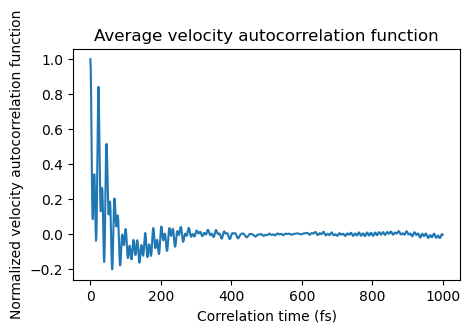

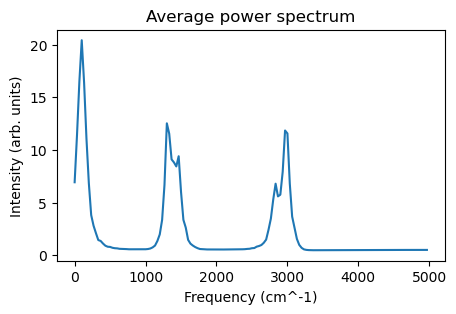

In [38]:
plot_vacf(vacf_jobs)
plot_power_spectrum(vacf_jobs)

Let's compare the power spectrum to the calculated frequencies from a gasphase geometry optimization + frequencies calculation (harmonic approximation). First, let's define and run the job. Remember: ``s`` is the UFF settings from before, and ``single_molecule`` is the single methane molecule defined before.

In [39]:
sfreq = Settings()
sfreq.input.ams.Task = "GeometryOptimization"
sfreq.input.ams.Properties.NormalModes = "Yes"
sfreq += s  # UFF engine settings used before
freq_job = AMSJob(
    settings=sfreq, name="methane-optfreq", molecule=single_molecule
)  # single_molecule defined at the beginning
freq_job.run()
print("Normal modes stored in {}".format(freq_job.results.rkfpath(file="engine")))

[16.12|14:00:54] JOB methane-optfreq STARTED
[16.12|14:00:54] JOB methane-optfreq RUNNING
[16.12|14:00:54] JOB methane-optfreq FINISHED
[16.12|14:00:54] JOB methane-optfreq SUCCESSFUL
Normal modes stored in /home/hellstrom/adfhome/userdoc/Tutorials/MolecularDynamicsAndMonteCarlo/MDintroPython/plams_workdir/methane-optfreq/forcefield.rkf


You can open the ``forcefield.rkf`` file in AMSspectra to visualize the vibrational normal modes. You can also access the frequencies in Python:

In [40]:
freqs = freq_job.results.get_frequencies()
print("There are {} frequencies for gasphase methane".format(len(freqs)))
for f in freqs:
    print("{:.1f} cm^-1".format(f))

There are 9 frequencies for gasphase methane
1310.1 cm^-1
1310.1 cm^-1
1310.1 cm^-1
1467.4 cm^-1
1467.4 cm^-1
2783.4 cm^-1
2942.0 cm^-1
2942.0 cm^-1
2942.0 cm^-1


Let's make something similar to a power spectrum by placing a Gaussian at each normal mode frequency and compare to the power spectrum from the molecular dynamics.

First, define the ``gaussian`` and ``sumgaussians`` function to sum up Gaussian functions along an axis:

In [41]:
def gaussian(x, a, b, c):
    return a * np.exp(-((x - b) ** 2) / (2 * c**2))


def sumgaussians(x, a, b, c):
    # calculate the sum of gaussians centered at b for the different x values
    # use numpy array broadcasting by placing x in a row and b in a column
    x = np.reshape(x, (1, -1))  # row
    b = np.reshape(b, (-1, 1))  # column
    return np.sum(gaussian(x, a, b, c), axis=0)

Then, define the x-axis ``x``, and calculate the spectrum from the frequencies by placing gaussians centered at ``freqs`` with height controlled by ``a`` and width controlled by ``c``:

In [42]:
x = np.arange(5000)  # x axis
y = sumgaussians(x, a=2, b=freqs, c=30)  # intensities, use suitable numbers for a and c

Then compare to the power spectrum from MD:

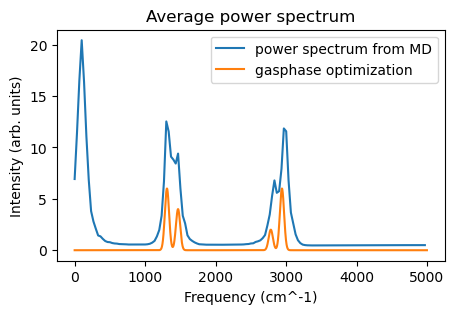

In [43]:
plot_power_spectrum(vacf_jobs)
plt.plot(x, y)
plt.legend(["power spectrum from MD", "gasphase optimization"])
plt.show()

The most striking difference is the intensity below 500 cm^-1 for the MD simulation. This arises from translational and rotational motion. There are also differences in the other peaks, arising from 

* intermolecular interactions, and
* anharmonicity, and
* sampling during the MD simulation

Note that the intensity is arbitrarily scaled for both the MD simulation and the gasphase optimization. The above do **not** correspond to IR or Raman spectra. They are power spectra.

## Density equilibration

Typically for liquids (but also for solids), you'd like to know what density your force field predicts at a given temperature.

For example, you might use the following workflow:

* ``packmol``: The initial system should have a much lower density than you expect
* ``AMSNVTJob``: Some initial MD is performed at this low density, which gives an implicit conformer search
* ``AMSMDScanDensityJob``: The box is then progressively scaled to a density higher than what you expect. Or you could just start directly with an ``AMSNPTJob`` (two steps down)
* ``AMSNVTJob``: The box size for which the energy was the lowest is used to run a short NVT simulation
* ``AMSNPTJob``: From the NVT simulation an NPT simulation is run
* The average density from the last third of the NPT simulation is used as the "equilibrated density". 
* ``AMSNPTJob.results.get_equilibrated_molecule()`` returns a molecule from the last third with a density as close as possible to the equilibrated density. 

UFF does not give very good densities. Let's instead try ReaxFF for liquid water. Note: parallelization in ReaxFF uses both MPI and OpenMP. To run in serial, you also need to set the ``OMP_NUM_THREADS`` variable to ``1``.

In [44]:
reaxff_s = Settings()
reaxff_s.input.ReaxFF.ForceField = "Water2017.ff"
reaxff_s.runscript.nproc = 1
reaxff_s.runscript.preamble_lines = ["export OMP_NUM_THREADS=1"]

Step 1: build the low density system with packmol:

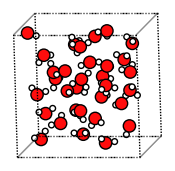

In [45]:
low_density_box = packmol(from_smiles("O"), n_molecules=32, region_names="water", density=0.4)
low_density_box = preoptimize(low_density_box, maxiterations=50)
show(low_density_box)

In [46]:
# step 2 : initial NVT at low density

nvt_low_density_job = AMSNVTJob(
    molecule=low_density_box,
    name="nvt_low_density_job",
    settings=reaxff_s,
    nsteps=3000,  # should be much larger for production purposes,
    temperature=300,
    tau=100,
    samplingfreq=500,
    timestep=0.5,
)
nvt_low_density_job.run();

[16.12|14:00:55] JOB nvt_low_density_job STARTED
[16.12|14:00:55] JOB nvt_low_density_job RUNNING
[16.12|14:01:04] JOB nvt_low_density_job FINISHED
[16.12|14:01:04] JOB nvt_low_density_job SUCCESSFUL


In [47]:
# step 3 : scan to higher density

scan_density_job = AMSMDScanDensityJob.restart_from(
    nvt_low_density_job, name="scan_density_job", scan_density_upper=1.4, nsteps=6000, samplingfreq=100
)
scan_density_job.run();

[16.12|14:01:04] JOB scan_density_job STARTED
[16.12|14:01:04] JOB scan_density_job RUNNING
[16.12|14:01:32] JOB scan_density_job FINISHED
[16.12|14:01:32] JOB scan_density_job SUCCESSFUL


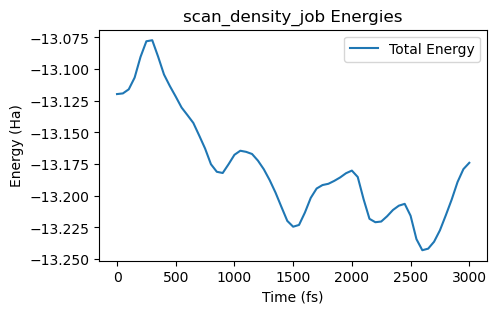

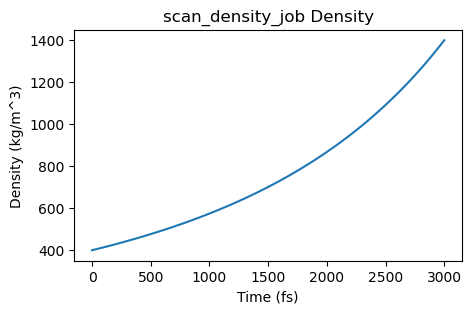

In [48]:
plot_energies(scan_density_job, kinetic_energy=False, potential_energy=False)
plot_density(scan_density_job)

Let's get the molecule where the energy is the lowest:

In [49]:
history_index = scan_density_job.results.get_lowest_energy_index("TotalEnergy", "MDHistory")
lowest_energy_molecule = scan_density_job.results.get_history_molecule(history_index)
lowest_energy_time = scan_density_job.results.get_property_at_step(history_index, "Time", "MDHistory")
print(f"Extracting frame {history_index}")
print(f"At MD-time: {lowest_energy_time:.1f} fs")
print(f"Density: {lowest_energy_molecule.get_density():.1f} kg/m^3")

Extracting frame 53
At MD-time: 2600.0 fs
Density: 1145.9 kg/m^3


In [50]:
# step 4 : short NVT equilibration at new density

nvt_equilibration_job = AMSNVTJob(
    molecule=lowest_energy_molecule,
    name="nvt_equilibration",
    settings=reaxff_s,
    nsteps=3000,
    timestep=0.5,
    temperature=300,
)
nvt_equilibration_job.run();

[16.12|14:01:32] JOB nvt_equilibration STARTED
[16.12|14:01:32] JOB nvt_equilibration RUNNING
[16.12|14:01:52] JOB nvt_equilibration FINISHED
[16.12|14:01:52] JOB nvt_equilibration SUCCESSFUL


In [51]:
# step 5 : long NPT equilibration

npt_equilibration = AMSNPTJob.restart_from(
    nvt_equilibration_job,
    name="npt_equilibration",
    nsteps=10000,  # should be much longer!
    temperature=300,
    thermostat="NHC",
    tau=100,
    barostat="MTK",
    equal="XYZ",
    pressure=1e5,
    barostat_tau=1000,
)

npt_equilibration.run();

[16.12|14:01:52] JOB npt_equilibration STARTED
[16.12|14:01:52] JOB npt_equilibration RUNNING
[16.12|14:02:49] JOB npt_equilibration FINISHED
[16.12|14:02:49] JOB npt_equilibration SUCCESSFUL


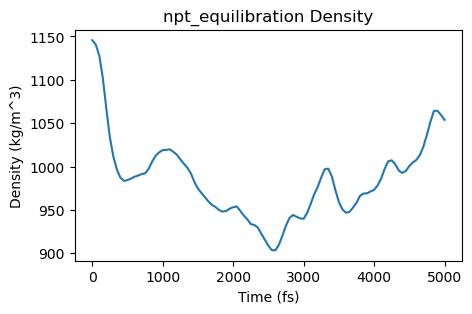

In [52]:
plot_density(npt_equilibration)

Let's get the equilibrated molecule (**note**: the above simulation was not long enough, there was no proper equilibration! The simulation should have run for longer).

Density: 995.76 kg/m^3


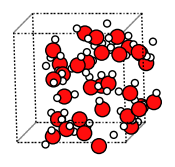

In [53]:
equilibrated_box = npt_equilibration.results.get_equilibrated_molecule()
print("Density: {:.2f} kg/m^3".format(equilibrated_box.get_density()))
equilibrated_box.write("water_equilibrated_box.xyz")
show(equilibrated_box)

## Diffusion coefficient supercell dependence

Because of finite-size effects, 
the calculated diffusion coefficient depends on the supercell size.

The below lines set up Lennard-Jones Argon simulations at a density of 1.0 g/mL and a temperature of 400 K for varying supercell sizes. The calculated diffusion coefficients (D) are plotted vs the inverse cubic box length (1/L), a linear fit is performed, and the extrapolated diffusion coefficient for "infinite" box size is read from the plot where 1/L = 0.

In [54]:
def get_lennard_jones_settings():
    s = Settings()
    s.input.lennardjones.eps = 3.785e-4
    s.input.lennardjones.rmin = 3.81637
    s.input.lennardjones.cutoff = 8.0
    s.runscript.nproc = 1  # to run in serial
    return s

Set up 3 systems with 50, 150, and 450 atoms. They all have the same density.

50 Ar atoms, density = 1.0 g/cm^3


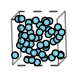

150 Ar atoms, density = 1.0 g/cm^3


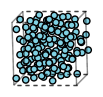

450 Ar atoms, density = 1.0 g/cm^3


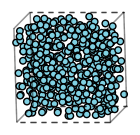

In [55]:
sizes = [50, 150, 450]  # number of atoms
inverted_L_list = []  # inverted cubic box length in angstrom
density = 1.0  # system density in g/cm^3

Ar = Molecule()
Ar.add_atom(Atom(symbol="Ar", coords=(0, 0, 0)))  # a single Ar atom

boxes = []

for size in sizes:
    mol = packmol(Ar, n_molecules=size, density=density)
    mol = preoptimize(mol, settings=get_lennard_jones_settings(), maxiterations=50)
    boxes.append(mol)
    L = mol.lattice[0][0]
    inverted_L_list.append(1.0 / L)
    print(f"{size} Ar atoms, density = {density} g/cm^3")
    show(mol, figsize=(L / 20, L / 20))
    plt.show()

For each system, run

* equilibration job (``eq_job``)
* production job (``prod_job``)
* MSD analysis on the production job (``msd_job``)

Store the calculated diffusion coefficients in ``D_list``

In [56]:
D_list = []  # diffusion coefficients
temperature = 400
max_correlation_time_fs = 6000
start_time_fit_fs = 3000

In [57]:
for size, mol in zip(sizes, boxes):
    eq_job = AMSNVTJob(
        name=f"eq_{size}",
        settings=get_lennard_jones_settings(),
        molecule=mol,
        temperature=temperature,
        nsteps=10000,
        samplingfreq=500,
        thermostat="Berendsen",
        tau=100,
        timestep=1.0,
        writebonds=False,
        writecharges=False,
        writemolecules=False,
        writevelocities=False,
    )
    eq_job.run()

    prod_job = AMSNVTJob.restart_from(
        eq_job, name=f"prod_{size}", nsteps=60000, samplingfreq=25, temperature=temperature, thermostat="NHC"
    )
    prod_job.run()

    msd_job = AMSMSDJob(prod_job, name=f"msd_{size}", max_correlation_time_fs=max_correlation_time_fs)
    msd_job.run()

    D = msd_job.results.get_diffusion_coefficient(start_time_fit_fs=start_time_fit_fs)
    D_list.append(D)
    log(f"{size} atoms: D = {D:.2e} m^2 s^-1")

[16.12|14:02:53] JOB eq_50 STARTED
[16.12|14:02:53] JOB eq_50 RUNNING
[16.12|14:02:55] JOB eq_50 FINISHED
[16.12|14:02:55] JOB eq_50 SUCCESSFUL
[16.12|14:02:55] JOB prod_50 STARTED
[16.12|14:02:55] JOB prod_50 RUNNING
[16.12|14:03:07] JOB prod_50 FINISHED
[16.12|14:03:07] JOB prod_50 SUCCESSFUL
[16.12|14:03:07] JOB msd_50 STARTED
[16.12|14:03:07] JOB msd_50 RUNNING
[16.12|14:03:07] JOB msd_50 FINISHED
[16.12|14:03:07] JOB msd_50 SUCCESSFUL
[16.12|14:03:07] 50 atoms: D = 2.20e-08 m^2 s^-1
[16.12|14:03:07] JOB eq_150 STARTED
[16.12|14:03:07] JOB eq_150 RUNNING
[16.12|14:03:11] JOB eq_150 FINISHED
[16.12|14:03:11] JOB eq_150 SUCCESSFUL
[16.12|14:03:11] JOB prod_150 STARTED
[16.12|14:03:11] JOB prod_150 RUNNING
[16.12|14:03:38] JOB prod_150 FINISHED
[16.12|14:03:38] JOB prod_150 SUCCESSFUL
[16.12|14:03:38] JOB msd_150 STARTED
[16.12|14:03:38] JOB msd_150 RUNNING
[16.12|14:03:38] JOB msd_150 FINISHED
[16.12|14:03:39] JOB msd_150 SUCCESSFUL
[16.12|14:03:39] 150 atoms: D = 2.38e-08 m^2 s^-1
[

In [58]:
from scipy.stats import linregress


def linear_fit_extrapolate_to_0(x, y):
    """
    linear regression on x and y.
    Returns 3-tuple fit_x, fit_y, slope.

    Note: fit_x contains an extra x-value at 0 (the final value). This ensures that the point at 0 is included when plotting.
    """
    result = linregress(x, y)
    fit_x = list(x) + [0]  # append a 0
    fit_x = np.array(fit_x)
    fit_y = result.slope * fit_x + result.intercept

    return fit_x, fit_y, result.slope, result.intercept

[16.12|14:05:14] Extrapolated (dilute) D: 2.76e-08 m² s⁻¹


Text(0, 0.5, 'Diffusion coefficient D (m² s⁻¹)')

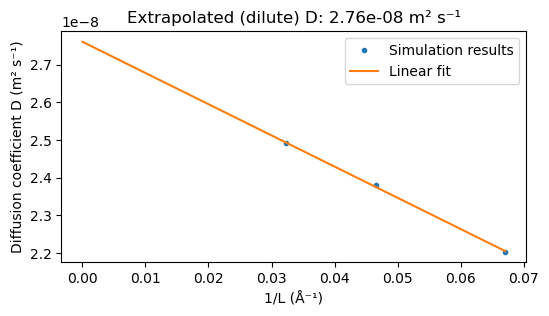

In [59]:
fit_x, fit_y, slope, intercept = linear_fit_extrapolate_to_0(inverted_L_list, D_list)

plt.figure(figsize=(6, 3))
plt.plot(inverted_L_list, D_list, ".", label="Simulation results")
plt.plot(fit_x, fit_y, label="Linear fit")
dilute_D = intercept  # at 0 inverted box length, what is the diffusion coefficient?
s = f"Extrapolated (dilute) D: {dilute_D:.2e} m² s⁻¹"
log(s)
plt.title(s)
plt.legend()
plt.xlabel("1/L (Å⁻¹)")
plt.ylabel("Diffusion coefficient D (m² s⁻¹)");

## Diffusion coefficient temperature dependence and running simulations in parallel

The diffusion coefficient follows an Arrhenius behavior with respect to the temperature. The below lines show how to calculate the prefactor $D_0$ and barrier $\Delta E$

$D(T) = D_0 \exp{\frac{-\Delta E}{kT}}$ 

$\ln D(T) = \ln D_0 - \frac{\Delta E}{k} \frac{1}{T}$

where $k = 8.617 \times 10^{-5}$ eV/K (the Boltzmann constant).

In this case, let's use an Ar box with 50 atoms, and run at temperatures of 50, 100, 200, and 300 K.

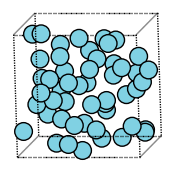

In [60]:
T_list = [50, 100, 200, 300]
mol = packmol(Ar, n_molecules=50, density=density)
mol = preoptimize(mol, settings=get_lennard_jones_settings(), maxiterations=50)
show(mol)

We want to run 4 identical simulations except for the temperature. If you have a machine with multiple cores, you can run them in parallel with a parallel PLAMS ``JobRunner``:

In [61]:
maxjobs = 4
config.default_jobrunner = JobRunner(parallel=True, maxjobs=maxjobs)

When using a parallel JobRunner in PLAMS, you should avoid accessing the results of previous jobs until absolutely necessary. This is needed to prevent PLAMS from waiting until a job has finished before continuing with the next one.

In the below loop,

* ``AMSNVTJob.restart_from`` has the argument ``use_prerun=True`` - this means that the initial molecule and velocities are read inside that job's ``prerun()`` method. Thus, PLAMS can continue in the loop without waiting for ``eq_job`` to finish.

* The ``msd_jobs`` list is created store the MSD jobs and their results without accessing them. Thus, PLAMS can continue with creating the next equilibration job for the next temperature at the top of the loop, without waiting for the ``msd_job`` to finish

Only after all the jobs have been run do we access the results of the MSD jobs in the final loop with ``msd_job.results.get_diffusion_coefficient()``

In [62]:
msd_jobs = []
DT_list = []
for T in T_list:
    eq_job = AMSNVTJob(
        name=f"eq_T_{T}",
        settings=get_lennard_jones_settings(),
        molecule=mol,
        temperature=T,
        nsteps=10000,
        samplingfreq=500,
        thermostat="Berendsen",
        tau=100,
        timestep=1.0,
        writebonds=False,
        writecharges=False,
        writemolecules=False,
        writevelocities=False,
    )
    eq_job.run()

    prod_job = AMSNVTJob.restart_from(
        eq_job,
        name=f"prod_T_{T}",
        nsteps=50000,
        samplingfreq=25,
        temperature=T,
        thermostat="NHC",
        use_prerun=True,  # only access the equilibration job results when the production job is about to start
    )
    prod_job.run()

    msd_job = AMSMSDJob(prod_job, name=f"msd_T_{T}", max_correlation_time_fs=max_correlation_time_fs)
    msd_job.run()
    msd_jobs.append(msd_job)  # do not access the msd results yet, wait until all jobs have been started

# now we can access the results
for T, msd_job in zip(T_list, msd_jobs):
    D = msd_job.results.get_diffusion_coefficient(start_time_fit_fs=start_time_fit_fs)
    DT_list.append(D)
    log(f"Temperature {T} K: D = {D:.2e} m^2 s^-1")

[16.12|14:05:15] JOB eq_T_50 STARTED
[16.12|14:05:15] JOB prod_T_50 STARTED
[16.12|14:05:15] JOB eq_T_50 RUNNING
[16.12|14:05:15] Waiting for job eq_T_50 to finish
[16.12|14:05:15] JOB msd_T_50 STARTED
[16.12|14:05:15] JOB eq_T_100 STARTED
[16.12|14:05:15] JOB prod_T_100 STARTED
[16.12|14:05:15] Waiting for job prod_T_50 to finish
[16.12|14:05:15] JOB msd_T_100 STARTED
[16.12|14:05:15] JOB eq_T_100 RUNNING
[16.12|14:05:15] Waiting for job eq_T_100 to finish
[16.12|14:05:15] JOB eq_T_200 STARTED
[16.12|14:05:15] JOB prod_T_200 STARTED
[16.12|14:05:15] Waiting for job prod_T_100 to finish
[16.12|14:05:15] JOB msd_T_200 STARTED
[16.12|14:05:15] JOB eq_T_200 RUNNING
[16.12|14:05:15] JOB eq_T_300 STARTED
[16.12|14:05:15] Waiting for job eq_T_200 to finish
[16.12|14:05:15] Waiting for job prod_T_200 to finish
[16.12|14:05:15] JOB prod_T_300 STARTED
[16.12|14:05:15] JOB msd_T_300 STARTED
[16.12|14:05:15] Waiting for job eq_T_300 to finish
[16.12|14:05:15] Waiting for job msd_T_50 to finish
[1

[16.12|14:05:27] D0: 2.75e-08 m² s⁻¹. Barrier: 0.013 eV


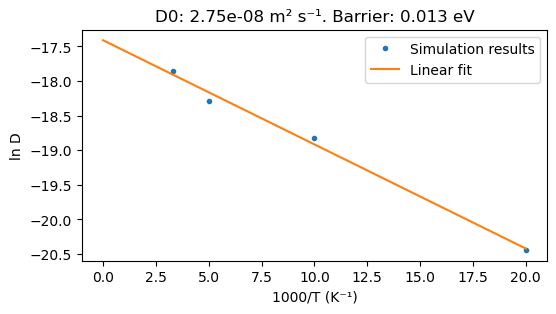

In [63]:
# fit a straight line when plotting ln(d) vs. 1/T
inverted_T_list = 1.0 / np.array(T_list)
ln_D_list = np.log(DT_list)
fit_x, fit_y, slope, intercept = linear_fit_extrapolate_to_0(inverted_T_list, ln_D_list)

D0 = np.exp(intercept)
boltzmann_eV_per_K = 8.617e-5  # eV/K
barrier = -boltzmann_eV_per_K * slope
title = f"D0: {D0:.2e} m² s⁻¹. Barrier: {barrier:.3f} eV"
log(title)

# multiply x-axis by 1000 for friendlier numbers
plt.figure(figsize=(6, 3))
plt.plot(inverted_T_list * 1000, ln_D_list, ".", label="Simulation results")
plt.plot(fit_x * 1000, fit_y, label="Linear fit")
plt.title(title)
plt.legend()
plt.xlabel("1000/T (K⁻¹)")
plt.ylabel("ln D");